<a href="https://colab.research.google.com/github/krishna11-dot/pageflip-cv-detection/blob/main/cv_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 Starting page flip detection training...
Checking directory structure:
Base path: /content/drive/MyDrive/images
Images path: /content/drive/MyDrive/images/images

Processing training data...
training/flip: 1162 images found
training/notflip: 1230 images found

Processing testing data...
testing/flip: 290 images found
testing/notflip: 307 images found

📊 Dataset Overview:
--------------------------------------------------
Total number of images: 2989

📁 Distribution by split:
split
training    2392
testing      597
Name: count, dtype: int64

🏷️ Distribution by label:
0 (NotFlip): 1537
1 (Flip): 1452

📊 Detailed distribution:
          NotFlip  Flip
split                  
testing       307   290
training     1230  1162

🎥 Unique videos in each split:
split
testing     65
training    65
Name: video_id, dtype: int64
Using CPU for training

Epoch 1/5
----------

Training: 100%|██████████| 150/150 [04:51<00:00,  1.95s/it]


Training Loss: 0.2635 F1: 0.8758


Validation: 100%|██████████| 38/38 [01:49<00:00,  2.88s/it]


Validation Loss: 0.1093 F1: 0.9618

Epoch 2/5
----------


Training: 100%|██████████| 150/150 [01:44<00:00,  1.43it/s]


Training Loss: 0.1310 F1: 0.9496


Validation: 100%|██████████| 38/38 [00:25<00:00,  1.47it/s]


Validation Loss: 0.0553 F1: 0.9852
Early stopping triggered


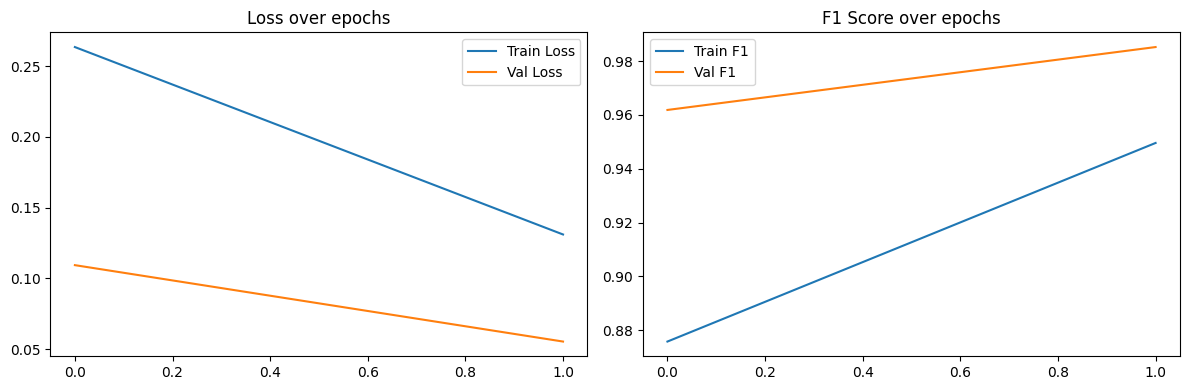


✅ Training complete!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# PyTorch imports
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

# Set the base path
base_path = "/content/drive/MyDrive/images"

def create_dataset_df(base_path):
    """Create a DataFrame containing image paths and labels"""
    data = []
    images_path = os.path.join(base_path, 'images')

    print(f"Checking directory structure:")
    print(f"Base path: {base_path}")
    print(f"Images path: {images_path}")

    for split in ['training', 'testing']:
        split_path = os.path.join(images_path, split)
        print(f"\nProcessing {split} data...")

        for label in ['flip', 'notflip']:
            label_path = os.path.join(split_path, label)

            if not os.path.exists(label_path):
                print(f"Warning: Path does not exist: {label_path}")
                continue

            files = [f for f in os.listdir(label_path) if f.endswith('.jpg')]
            print(f"{split}/{label}: {len(files)} images found")

            for img_name in files:
                try:
                    video_id = img_name.split('_')[0]
                    frame_number = img_name.split('_')[1].split('.')[0]

                    data.append({
                        'image_path': os.path.join(label_path, img_name),
                        'label': 1 if label == 'flip' else 0,
                        'video_id': video_id,
                        'frame_number': frame_number,
                        'split': split
                    })
                except Exception as e:
                    print(f"Error processing {img_name}: {str(e)}")

    return pd.DataFrame(data)

def analyze_dataset(df):
    """Print dataset statistics"""
    print("\n📊 Dataset Overview:")
    print("-" * 50)
    print(f"Total number of images: {len(df)}")

    print("\n📁 Distribution by split:")
    print(df['split'].value_counts())

    print("\n🏷️ Distribution by label:")
    label_dist = df['label'].value_counts()
    print("0 (NotFlip):", label_dist[0])
    print("1 (Flip):", label_dist[1])

    print("\n📊 Detailed distribution:")
    dist_matrix = pd.crosstab(df['split'], df['label'])
    dist_matrix.columns = ['NotFlip', 'Flip']
    print(dist_matrix)

    print("\n🎥 Unique videos in each split:")
    print(df.groupby('split')['video_id'].nunique())

class PageFlipDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label']

        with Image.open(img_path) as img:
            img = img.convert('RGB').resize((96, 96))  # Reduced size
            if self.transform:
                img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float32)

class LighterCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(32 * 12 * 12, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            return True
        return False

def get_transforms():
    """Simplified transforms"""
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    return train_transform, train_transform

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    print("Using CPU for training")

    early_stopping = EarlyStopping(patience=2)
    best_f1 = 0.0
    history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_f1 = 0.0

        for inputs, labels in tqdm(train_loader, desc='Training'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_f1 += (outputs.squeeze().round() == labels).float().mean()

        epoch_loss = running_loss / len(train_loader)
        epoch_f1 = running_f1 / len(train_loader)

        print(f'Training Loss: {epoch_loss:.4f} F1: {epoch_f1:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_f1 = 0.0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation'):
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()
                val_f1 += (outputs.squeeze().round() == labels).float().mean()

        val_loss = val_loss / len(val_loader)
        val_f1 = val_f1 / len(val_loader)

        print(f'Validation Loss: {val_loss:.4f} F1: {val_f1:.4f}')

        # Save best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')

        # Update history
        history['train_loss'].append(epoch_loss)
        history['train_f1'].append(epoch_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)

        # Early stopping check
        if early_stopping(val_loss):
            print("Early stopping triggered")
            break

    return model, history

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss over epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_f1'], label='Train F1')
    plt.plot(history['val_f1'], label='Val F1')
    plt.title('F1 Score over epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("🚀 Starting page flip detection training...")

    # Create and analyze dataset
    df = create_dataset_df(base_path)
    analyze_dataset(df)

    # Split data
    train_df = df[df['split'] == 'training']
    test_df = df[df['split'] == 'testing']

    # Create datasets and dataloaders
    train_transform, val_transform = get_transforms()

    train_dataset = PageFlipDataset(train_df, transform=train_transform)
    test_dataset = PageFlipDataset(test_df, transform=val_transform)

    train_loader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Initialize model and training components
    model = LighterCNN()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    model, history = train_model(model, train_loader, test_loader, criterion, optimizer)

    # Plot results
    plot_training_history(history)

    print("\n✅ Training complete!")